# 1-1 AutoEncoder

<img src="./img/ae.png" alt="autoencoder" width="500" align="left"/>

### 모듈 임포트

- os (디렉토리 생성)
- tensorflow (학습)
- numpy (랜덤데이터 플로팅)
- matplotlib.pyplot (플로팅)
- matplotlib.gridspec (플로팅)

In [1]:
import os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec

### Logging Directory 설정

In [2]:
CKPT_DIR = "../generated_output/AE"

### 학습 변수 설정

- learning rate : gradient descent시 적용할 학습률
- training steps : training 종료조건
- batch size : 1 step에 feed forward할 배치 크기

- 1 step에 batch size만큼의 데이터를 feed forward하기 때문에, step * batch size = feed forward된 데이터 샘플수
- 1 epoch은 총 sample수를 사용하여 학습한 것을 의미하므로, feed forward된 sample수 / 데이터 sample수 = epoch수

In [3]:
LEARNING_RATE = 1e-4
TRAINING_STEPS = 120000
BATCH_SIZE = 100

### 네트워크 변수 설정

- image dimension : 이미지 차원, MNIST가 28x28이므로 총 784차원의 벡터
- latent dimension : 임베딩할 차원
- encoder hidden dimension : 인코더 파트의 은닉층 차원
- decoder hidden dimension : 디코더 파트의 은닉층 차원

In [4]:
IMAGE_DIM = 784
LATENT_DIM = 10
ENDOCER_HIDDEN_DIM = 256
DECODER_HIDDEN_DIM = 256
graph = tf.Graph()

### Encoder 함수 정의

[batch_size, 784]

$\rightarrow$ Dense(784, 256) $\rightarrow$ relu $\rightarrow$ [batch_size, 256]

$\rightarrow$ Dense(256, 10) $\rightarrow$ sigmoid $\rightarrow$ [batch_size, 10]

#### Initialization 구현

shape = [784, 256]일 때, 이에 대한 weight initialization 구현법  
(실용 코드에서는 tensorflow. initializers에 함수로 구현되어, 호출만 하면 됨)

1. Lecun initialization

> tf.random_normal(shape=[shape], stddev=tf.sqrt(1. / (shape[0]))

2. Glorot initialization

> tf.random_normal(shape=[shape], stddev=tf.sqrt(2. / (shape[0] + shape[1])))

3. He initialization

> tf.random_normal(shape=[shape], stddev=tf.sqrt(2. / shape[0]))


In [5]:
def encoder_model(feature):
    
    with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
        
        net = feature
            
        net = tf.layers.dense(
            net, ENDOCER_HIDDEN_DIM, 
            activation=tf.nn.relu, 
            kernel_initializer=tf.initializers.he_normal())
        # tf.layers.dense(input, output dim)
        # hidden layer의 activation function은 relu를 씀 (gradient vanishing 방지)
        # initializer은 he initialization을 씀 (relu에 최적화, stddev = sqrt(2/fan_in))
                    
        net = tf.layers.dense(
            net, LATENT_DIM, 
            activation=tf.nn.sigmoid, 
            kernel_initializer=tf.initializers.he_normal())
        # output layer
        # output layer의 activation function은 sigmoid를 씀 (0 ~ 1로 mapping)
        
        return net
        # output layer을 거친 tensor을 리턴

### Decoder 함수 정의

[batch_size, 10]

$\rightarrow$ Dense(10, 256) $\rightarrow$ relu $\rightarrow$ [batch_size, 256]

$\rightarrow$ Dense(256, 784) $\rightarrow$ sigmoid $\rightarrow$ [batch_size, 784]

In [6]:
def decoder_model(feature):
    
    with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
        
        net = feature
            
        net = tf.layers.dense(
            net, DECODER_HIDDEN_DIM, 
            activation=tf.nn.relu, 
            kernel_initializer=tf.initializers.he_normal())
        # tf.layers.dense(input, output dim)
        # 반복문을 통해 hidden dimension 리스트 형태로 hidden layer 구성
        # hidden layer의 activation function은 relu를 씀 (gradient vanishing 방지)
        # initializer은 he initialization을 씀 (relu에 최적화, stddev = sqrt(2/fan_in))
            
        net = tf.layers.dense(
            net, IMAGE_DIM, 
            activation=tf.nn.sigmoid, 
            kernel_initializer=tf.initializers.he_normal())
        # output layer
        # output layer의 activation function은 sigmoid를 씀 (0~1로 mapping)
        
        return net
        # output layer을 거친 tensor을 리턴

### Input Function 정의

feature

$\rightarrow$ Dataset 생성 $\rightarrow$ 데이터 사이즈로 랜덤 셔플링 $\rightarrow$ 데이터 모두 소모시 처음부터 반복

$\rightarrow$ batch 생성 $\rightarrow$ batch 한 개씩 소모하는 iterator $\rightarrow$ iterator 호출

In [7]:
def train_input_fn(features, batch_size=BATCH_SIZE):
    
    with graph.as_default():
        
        dataset = tf.data.Dataset.from_tensor_slices(features)
        # 인풋값으로부터 Dataset객체 생성
        batch_dataset = dataset.shuffle(features.shape[0]).repeat().batch(batch_size)
        # Dataset 셔플링, 반복, 배치화
        return batch_dataset.make_one_shot_iterator().get_next()
        # 단일 배치 반복자 리턴

### AutoEncoder 학습 함수 정의

[batch_size, 784]

$\rightarrow$ Dense(784, 256) $\rightarrow$ relu $\rightarrow$ [batch_size, 256]

$\rightarrow$ Dense(256, 10) $\rightarrow$ sigmoid $\rightarrow$ [batch_size, 10]

$\rightarrow$ Dense(10, 256) $\rightarrow$ relu $\rightarrow$ [batch_size, 256]

$\rightarrow$ Dense(256, 784) $\rightarrow$ sigmoid $\rightarrow$ [batch_size, 784]

In [8]:
def train(features):
    
    if not os.path.exists(CKPT_DIR):
        os.makedirs(CKPT_DIR)
    # logging directory 생성
        
    with graph.as_default():
        
        features = train_input_fn(features)
        # feature 받아서 batch로 넘겨주는 그래프 작성
        
        latents = encoder_model(features)
        # batch를 encoder에 적용하여 latent를 추출하는 그래프 작성
        
        outputs = decoder_model(latents)
        # latent를 decoder에 적용하여 복원하는 그래프 작성
        
        loss = tf.losses.mean_squared_error(features, outputs)
        # loss는 input feature와 MSE로 정의
        
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
        # backpropagation operation 정의
        # optimizer은 ADAM 적용, 설정한 learning rate 적용
                
        saver = tf.train.Saver()                                 
        # checkpoint 저장할 Saver객체 생성
        
        with tf.Session() as sess:
        # Session객체 생성, 컨텍스트 매니저로 자원 관리
            
            sess.run(tf.global_variables_initializer())
            # weight 초기화

            for step in range(TRAINING_STEPS):
                
                step += 1
                                
                loss_now, _ = sess.run([loss, optimizer])
                # feedforward, backpropagation 실행
                # Plotting할 embedding assigning operation도 같이 실행
                # 한 번의 run을 통해 실행해야 batch iterator가 한 번만 실행됨에 유의
                                
                if (step == TRAINING_STEPS):                
                    saver.save(sess, CKPT_DIR + '/ae.ckpt')
                    # 학습된 weights에 대한 checkpoint 저장
                    
                if (step % 1000 == 0):
                    print('steps: {}/{}, loss: {:.4f}'.format(step, TRAINING_STEPS, loss_now))
                    # 학습과정 로깅

### MNIST 데이터 로드 및 전처리
- MNIST 데이터 로드
- normalize
- flatten

In [9]:
(x_train, y_train), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
# MNIST 데이터 로드 (keras.datesets 모듈 이용)

x_train = x_train / 255.
x_test = x_test / 255.
# MNIST 데이터 normalize (0~1로 mapping)

x_train = x_train.reshape([-1, IMAGE_DIM]).astype(np.float32)
x_test = x_test.reshape([-1, IMAGE_DIM]).astype(np.float32)
# MNIST 데이터 vectorization

### AutoEncoder 학습

In [10]:
train(x_train)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
steps: 1000/120000, loss: 0.0343
steps: 2000/120000, loss: 0.0257
steps: 3000/120000, loss: 0.0219
steps: 4000/120000, loss: 0.0217
steps: 5000/120000, loss: 0.0218
steps: 6000/120000, loss: 0.0209
steps: 7000/120000, loss: 0.0192
steps: 8000/120000, loss: 0.0200
steps: 9000/120000, loss: 0.0191
steps: 10000/120000, loss: 0.0185
steps: 11000/120000, loss: 0.0180
steps: 12000/120000, loss: 0.0208
steps: 13000/120000, loss: 0.0181
steps: 14000/120000, loss: 0.0183
steps: 15000/120000, loss: 0.0179
steps: 16000/120000, loss: 0.0175
steps: 17000/120000, loss: 0.0167
steps: 18000/120000, loss: 0.0177
steps: 19000/120000, loss: 0.0163
steps: 20000/120000, loss: 0.0179
steps: 21000/120000, loss: 0.0153
steps: 22000/120000, loss: 0.0170
steps: 23000/120000, loss: 0.0162
steps: 24000/120000, loss: 0.0170
steps: 25000/1

### Reconstruction Plotting 함수 정의

In [25]:
def recon_25_image_plot(features):
    
    with graph.as_default():
        
        dataset = tf.data.Dataset.from_tensor_slices(features)
        batch_dataset = dataset.batch(25)
        features = batch_dataset.make_one_shot_iterator().get_next()
        # plotting batch 생성
        
        latents = encoder_model(features)
        # vector을 encoder에 적용하여 latent 추출
        
        recon = decoder_model(latents)
        # latent를 decoder에 적용하여 복원
        
        fig = plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(5, 5)
        gs.update(wspace=0.05)
        # 플로팅 사이즈, 배열, 간격 정의
        
        saver = tf.train.Saver()
        # weight restoring 진행할 Saver 객체 생성
        
        with tf.Session() as sess:
            
            saver.restore(sess, tf.train.latest_checkpoint(CKPT_DIR))
            # checkpoint로부터 weight 복원
            
            recon_image = sess.run(recon)
            # reconstruction operation 진행
            
            recon_image = recon_image.reshape([-1, 28, 28])
            # tensorization
            
            for i in range(25):
                plt.subplot(gs[i])
                plt.axis('off')
                plt.imshow(recon_image[i], cmap = 'gray')
            # reconstructed image plotting

### Original Image Plotting 함수 정의

In [21]:
def origin_25_image_plot(features):
    features = features.reshape([-1, 28, 28])
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.05)
    for i in range(25):
        plt.subplot(gs[i])
        plt.axis('off')
        plt.imshow(features[i], cmap = 'gray')

### Reconstruction Plot

INFO:tensorflow:Restoring parameters from ../generated_output/AE/ae.ckpt


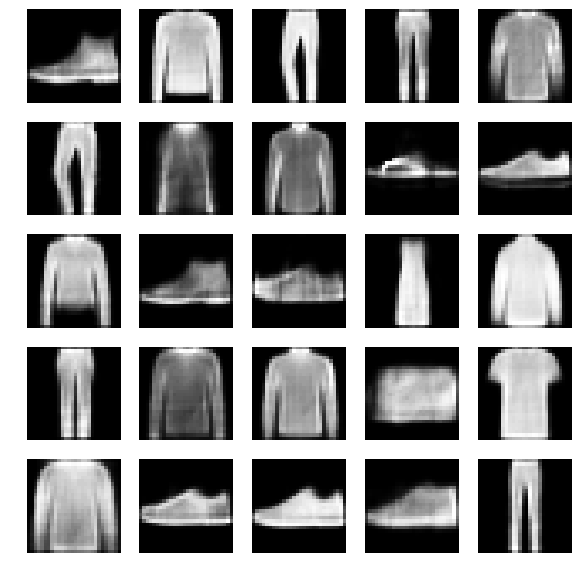

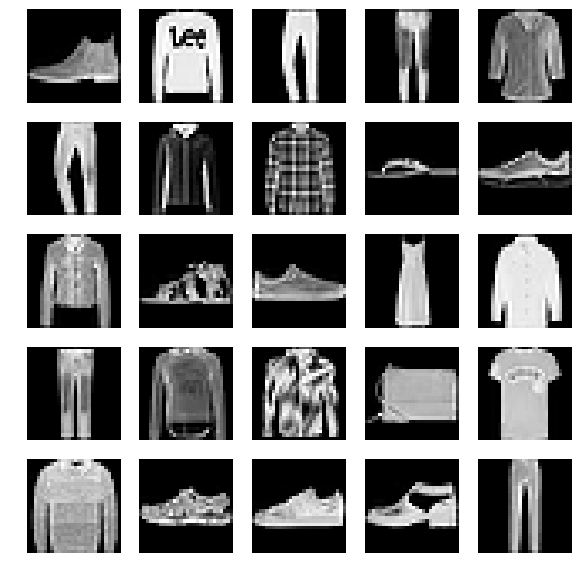

In [26]:
recon_25_image_plot(x_test[:25])
origin_25_image_plot(x_test[:25])

### Random Plotting 함수 정의

In [19]:
def random_25_image_plot(seed=None):
    
    with graph.as_default():
        
        np.random.seed(seed)
        random_noise = np.random.normal(size=[25, LATENT_DIM]).astype(np.float32)
        # latent 형태의 random noise 생성
        
        random_noise_input = train_input_fn(random_noise, batch_size=25)
        # random noise tensor 생성
        
        random_gen = decoder_model(random_noise_input)
        # random noise를 decoder에 적용, MNIST image 차원으로 임베딩

        fig = plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(5, 5)
        gs.update(wspace=0.05)
        # 플로팅 사이즈, 배열, 간격 정의
        
        saver = tf.train.Saver()
        # weight restoring 진행할 Saver 객체 생성
        
        with tf.Session() as sess:
            
            saver.restore(sess, tf.train.latest_checkpoint(CKPT_DIR))
            # checkpoint로부터 weight 복원
            
            random_image = sess.run(random_gen)
            # random generation operation 진행
            
            random_image = random_image.reshape([-1, 28, 28])
            # tensorization
            
            for i in range(25):
                plt.subplot(gs[i])
                plt.axis('off')
                plt.imshow(random_image[i], cmap = 'gray')
            # plotting

### Random Plot

INFO:tensorflow:Restoring parameters from ../generated_output/AE/ae.ckpt


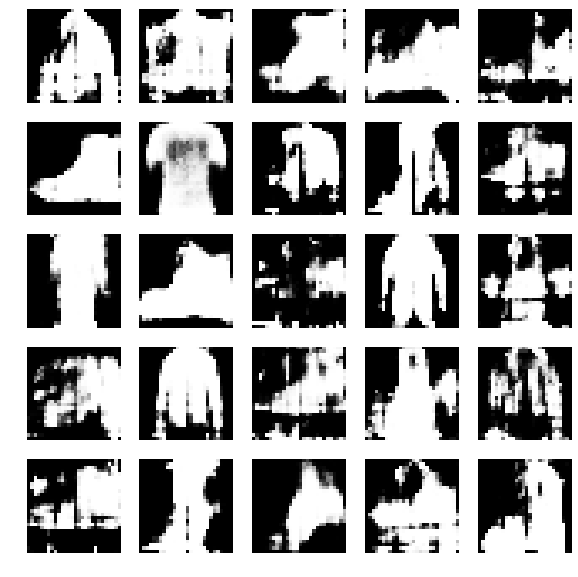

In [20]:
random_25_image_plot()